https://numbersandshapes.net/post/fitting_sir_to_data_in_python/

In [1]:
import numpy as np
import pandas as pd
import os, yaml, datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Lecture du fichier d'environnement
ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR,
                         params['directories']['processed'],
                         params['files']['all_data'])

# Lecture du fichier de données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=['Last Update'])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df['day'] <= datetime.date(2020, 3, 12)])


In [3]:
epidemie_df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,source,day
0,Hubei,Mainland China,2020-02-26 14:13:10,65187.0,2615.0,20969.0,30.9756,112.2707,02-26-2020.csv,2020-02-26
1,Guangdong,Mainland China,2020-02-26 10:33:02,1347.0,7.0,851.0,23.3417,113.4244,02-26-2020.csv,2020-02-26
2,Henan,Mainland China,2020-02-26 10:33:02,1271.0,19.0,1033.0,33.8820,113.6140,02-26-2020.csv,2020-02-26
3,NaN,South Korea,2020-02-26 11:03:11,1261.0,12.0,22.0,36.0000,128.0000,02-26-2020.csv,2020-02-26
4,Zhejiang,Mainland China,2020-02-26 10:33:02,1205.0,1.0,867.0,29.1832,120.0934,02-26-2020.csv,2020-02-26


In [4]:
def get_country(self, country):
    # self: le 1er element dans la founction (dans notre cas epidemie_df)
    return (epidemie_df[epidemie_df['Country/Region']==country]
             .groupby(['Country/Region', 'day'])
             .agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'})
             .reset_index())

# Monkey patch pd.DataFrame
pd.DataFrame.get_country = get_country 

In [5]:
korea_df = get_country(epidemie_df, 'South Korea')
italy_df = get_country(epidemie_df, 'Italy')
france_df = get_country(epidemie_df, 'France')

In [6]:
korea_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered
38,South Korea,2020-03-05,6088.0,35.0,41.0
39,South Korea,2020-03-06,6593.0,42.0,135.0
40,South Korea,2020-03-07,7041.0,44.0,135.0
41,South Korea,2020-03-08,7314.0,50.0,118.0
42,South Korea,2020-03-09,7478.0,53.0,118.0


SIR: S = susceptible, I = Infected, R = Recovered  
I = I_t-I_(t-1)

In [97]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()
france_df['infected'] = france_df['Confirmed'].diff()

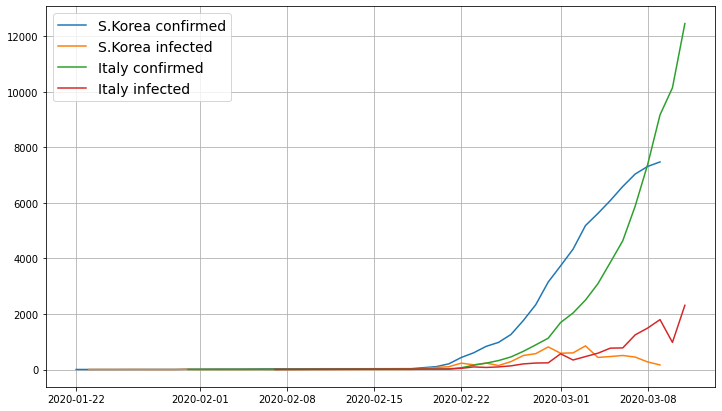

In [8]:
fig = plt.figure(figsize=(12,7))
plt.plot(korea_df['day'], korea_df['Confirmed'], label='S.Korea confirmed')
plt.plot(korea_df['day'], korea_df['infected'], label='S.Korea infected')

plt.plot(italy_df['day'], italy_df['Confirmed'], label='Italy confirmed')
plt.plot(italy_df['day'], italy_df['infected'], label='Italy infected')

plt.legend(fontsize=14)
plt.grid(True)
plt.show()

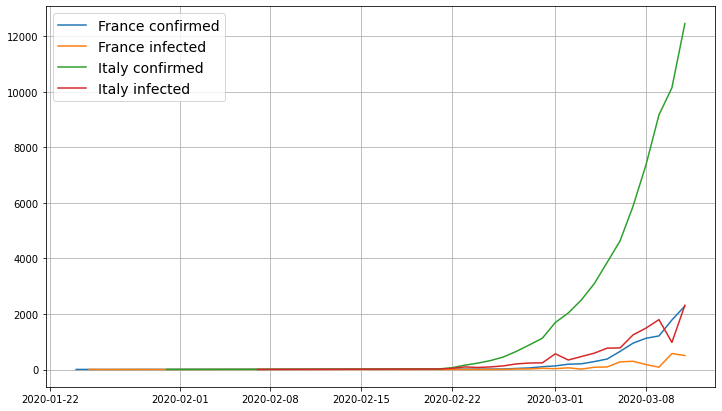

In [52]:
fig = plt.figure(figsize=(12,7))
plt.plot(france_df['day'], france_df['Confirmed'], label='France confirmed')
plt.plot(france_df['day'], france_df['infected'], label='France infected')

plt.plot(italy_df['day'], italy_df['Confirmed'], label='Italy confirmed')
plt.plot(italy_df['day'], italy_df['infected'], label='Italy infected')

plt.legend(fontsize=14)
plt.grid(True)
plt.show()

In [53]:
def SIR(t, y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I, gamma*I])


In [54]:
korea_df.loc[2:].head()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
2,South Korea,2020-01-24,2.0,0.0,0.0,1.0
3,South Korea,2020-01-25,2.0,0.0,0.0,0.0
4,South Korea,2020-01-26,3.0,0.0,0.0,1.0
5,South Korea,2020-01-27,4.0,0.0,0.0,1.0
6,South Korea,2020-01-28,4.0,0.0,0.0,0.0


This [solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) function numerically integrates a system of ordinary differential equations given an initial value.

In [55]:
from scipy.integrate import solve_ivp
beta,gamma = [0.0001,0.1]

# function, interval de temps, subceptible(pop total)
solution_korea = solve_ivp(SIR, [0, 40], [51_470_000, 1, 0], t_eval=np.arange(0, 40, 1))

In [56]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 105848
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[ 5.14700000e+07, -5.63598505e-07, -5.35886883e-07,
         7.25259450e-08, -4.92941891e-07, -1.38957149e-06,
        -1.95764753e-07, -1.27900437e-06, -8.31951714e-07,
         5.42201272e-07,  1.56435316e-06, -1.19062111e-06,
         8.72801924e-07,  3.86525105e-07,  1.83842126e-07,
         2.05974543e-06, -8.42187524e-07,  6.56482746e-07,
        -1.19313991e-06,  3.05324322e-07, -4.09856043e-07,
        -2.71294152e-07,  1.17312716e-06,  6.72978258e-07,
        -2.60289765e-07, -1.05505570e-06,  1.89828332e-06,
         1.38906170e-06, -1.18091175e-06, -8.24276034e-07,
         5.36667511

In [61]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(12,5))

    plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-")
    plt.plot(solution.t, solution.y[2],"g-")
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.legend(["Susceptible","Infected","Removed","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()

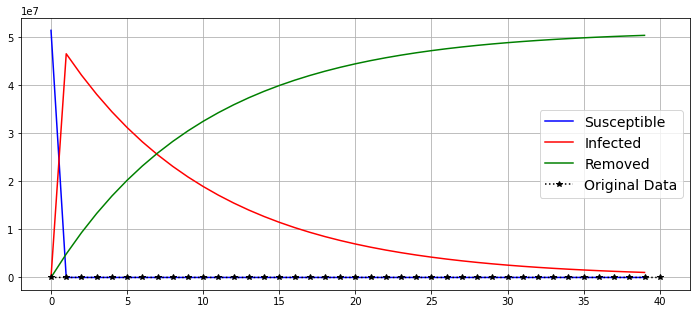

In [62]:
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])

In [70]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 26612
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[ 5.14700000e+07,  4.73700386e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e-08,  4.73700279e-08,  4.73700279e-08,
         4.73700279e

In [111]:
def sumsq_error(p):
    beta, gamma = p
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I, gamma*I])

    sol = solve_ivp(SIR, [0, nb_steps], [total_population, 1, 0], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((sol.y[1]-infected_population)**2))


In [125]:
total_population = 51_470_000
infected_population = korea_df.loc[29:]['infected']
nb_steps = len(infected_population)
infected_population

29    144.0
30    284.0
31    505.0
32    571.0
33    813.0
34    586.0
35    599.0
36    851.0
37    435.0
38    467.0
39    505.0
40    448.0
41    273.0
42    164.0
Name: infected, dtype: float64

In [ ]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 1], method='Powell')

In [ ]:
msol

In [128]:
beta, gamma = msol.x
# function, interval de temps, subceptible(pop total)
solution_korea = solve_ivp(SIR, [0, nb_steps], [51_470_000, 1, 0], t_eval=np.arange(0, nb_steps, 1))

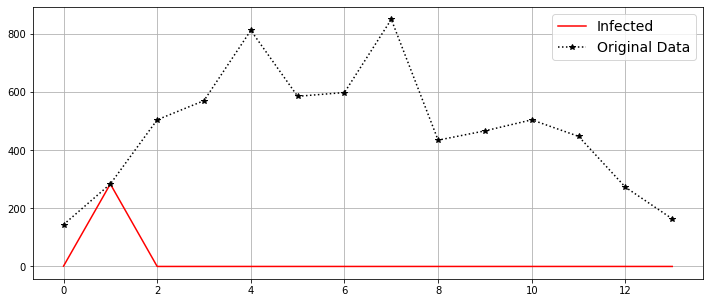

In [129]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(12,5))

    #plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-")
    #plt.plot(solution.t, solution.y[2],"g-")
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.legend(["Infected","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()
    
plot_epidemia(solution_korea, korea_df.loc[29:]['infected'])

In [98]:
china_df = epidemie_df.get_country('Mainland China').loc[:48]
china_df['infected'] = china_df['Confirmed'].diff()
china_df.tail()

,Country/Region,day,Confirmed,Deaths,Recovered,infected
44,Mainland China,2020-03-06,79771.0,3029.0,53172.0,306.0
45,Mainland China,2020-03-07,78619.0,3051.0,53511.0,-1152.0
46,Mainland China,2020-03-08,79455.0,3084.0,56114.0,836.0
47,Mainland China,2020-03-09,76902.0,3071.0,55004.0,-2553.0
48,Mainland China,2020-03-10,77201.0,3088.0,56620.0,299.0


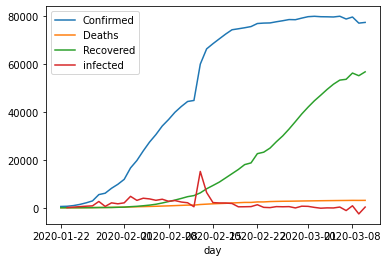

In [99]:
china_df.set_index('day').plot.line(figsize=(12,7))

In [100]:
%%time
beta, gamma = 0.001, 0.1

total_population = 1_350_000_000
infected_population = china_df.loc[2:]['infected']
nb_steps = len(infected_population)

solution_china = solve_ivp(SIR, [0, 40], [1_350_000_000, 1, 0], t_eval=np.arange(0, 40, 1))

KeyboardInterrupt: 

In [ ]:
def plot_epidemia(solution, infected):
    
    fig = plt.figure(figsize=(12,5))

    #plt.plot(solution.t, solution.y[0],"b-")
    plt.plot(solution.t, solution.y[1],"r-", labe)
    #plt.plot(solution.t, solution.y[2],"g-")
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.legend(["Infected","Original Data"], fontsize=14)
    plt.grid('True')
    plt.show()
    
plot_epidemia(solution_korea, korea_df.loc[2:]['infected'])